In [3]:
with open('key', 'r') as f: api_key = f.read()

In [4]:
from tqdm.auto import tqdm 
import pandas as pd
from skfin.plot import *
from skfin.datasets import load_fomc_statements
statements = load_fomc_statements(force_reload=False, cache_dir='./data')

INFO:skfin.datasets:logging from cache file: data/fomc_statements.parquet


In [5]:
text = statements['text'].iloc[0]
text

"The Federal Reserve released the following statement after today's Federal Open Market Committee meeting: While the FOMC did not take action today to alter the stance of monetary policy, the Committee was concerned about the potential for a buildup of inflationary imbalances that could undermine the favorable performance of the economy and therefore adopted a directive that is tilted toward the possibility of a firming in the stance of monetary policy. Trend increases in costs and core prices have generally remained quite subdued. But domestic financial markets have recovered and foreign economic prospects have improved since the easing of monetary policy last fall. Against the background of already-tight domestic labor markets and ongoing strength in demand in excess of productivity gains, the Committee recognizes the need to be alert to developments over coming months that might indicate that financial conditions may no longer be consistent with containing inflation."

In [6]:
from openai import OpenAI

client = OpenAI(api_key=api_key)

from tenacity import retry, stop_after_attempt, wait_random_exponential

In [35]:
categories = ['Monetary Policy', 'Economic Outlook', 'Inflation', 'Employment', 'Market Stability']

def system_(date, categories):
    return f"""
        Reset context. Analyze the following FOMC statement from {date} without using any knowledge beyond that date. 
        Provide a list of sentiment scores for each of the specified categories using a scale from 1 to 10, where 1 indicates a very negative sentiment, 5 indicates a neutral sentiment, and 10 indicates a very positive sentiment.
        Categories: {', '.join(categories)}
        Output template is the 5 ints, comma-separated, and without labels, e.g.: '5, 4, 4, 9, 1'
    """

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def chat_completion(user, date, categories, model="gpt-3.5-turbo"):
    try:
        response = client.chat.completions.create(
                model=model,
                messages=[
                    {"role": "system", "content": system_(date, categories)},
                    {"role": "user", "content": user},
                ],
                temperature=0,
            )
        values = [int(str_val) for str_val in response.choices[0].message.content.split(", ")]
    except Exception as e:
        print(e)
        values = [5] * len(categories)
    return dict(zip(categories, values))

In [39]:
for idx in range(len(statements)):
    text = statements['text'].iloc[idx]
    date = statements.index[idx].strftime("%Y-%m-%d")
    statements.loc[statements.index[idx], categories] = chat_completion(user=text, date=date, categories=categories).values()

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

In [44]:
statements.to_csv('statements_with_metrics.csv', index=True)

<AxesSubplot:xlabel='release_date'>

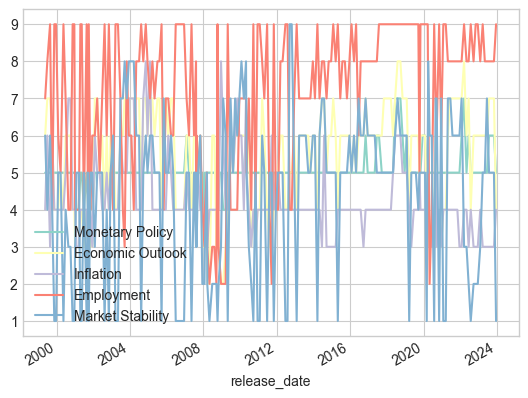

In [42]:
statements[categories].plot()

In [59]:
v = pd.Series({t: chat_completion(statements.loc[t, 'text'], system_(t)) for t in statements.index}).str.lower()
statements_ = statements.join(pd.get_dummies(v, dtype=float))

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"

Checking that indeed we received at most the four options. (It seems that the models rarely says "I don't know.")

In [67]:
v.value_counts()

neutral     135
increase     48
decrease     29
Name: count, dtype: int64

To get an intuition from the output of the LLM, we problem the cumulative difference of the dummies `hawkish - dovish`. We see clearly the tightening and accomodating phases of monetary policy:

- 1999 - 2001: tightening until the dot-com burst 
- 2001 - 2004: loosening of monetary policy 
- 2004 - 2007: tightening
- 2007 - 2017: long experiment with loosening, including with Quantitative Easing 
- 2017 - 2019: Quantitative tightening
- 2019 - 2021: economic slowdown (2019) preceding the Covid intervention
- 2022 - today: tightening due to high inflation

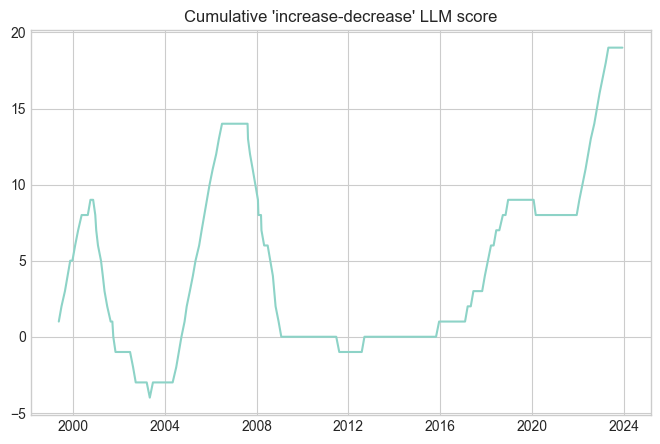

In [61]:
line(statements_.pipe(lambda x: x['increase'].sub(x['decrease'])), cumsum=True, legend=False, title="Cumulative 'increase-decrease' LLM score")

A similar picture is shown with the rolling 1-year (= 8 FOMC meetings) `hawkish-dovish` LLM score.

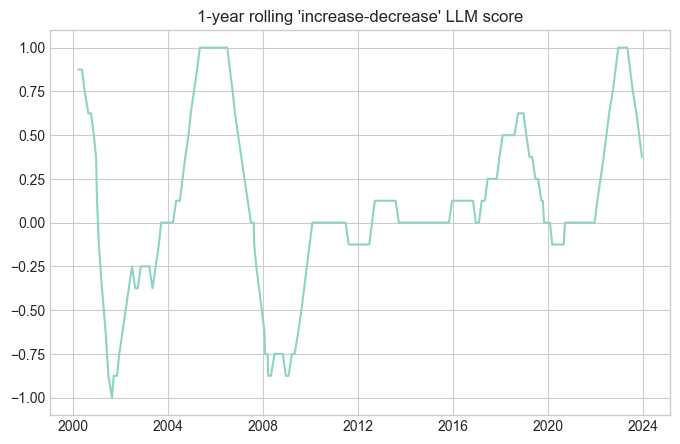

In [62]:
rolling_mean = statements_.pipe(lambda x: x['increase'].sub(x['decrease'])).rolling(window=8).mean().dropna().rename('llm-score')

line(
     rolling_mean, 
     legend=False, 
     title="1-year rolling 'increase-decrease' LLM score"
)


In [36]:
from cpilib import HICP

hicp = HICP.from_cache(time_limit=1, cache_folder='./data')

INFO:cpilib.cpi.hicp:Initializing HICP object...
INFO:cpilib.cpi.hicp:Loading HICP object from Eurostat...


/Users/thomaskientz/Library/Caches/pypoetry/virtualenvs/llm-inflation-H0PNBe9U-py3.9/lib/python3.9/site-packages/pandas/core/arrays/arrow/array.py:480: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result[valid] = op(np.array(self)[valid], other)


INFO:cpilib.cpi.hicp:Done.


In [63]:
hicp_prices = hicp.prices["EA19"]["CP00"]
hicp_yoy = hicp_prices.pct_change(12).dropna().rename('yoy')
hicp_yoy

1997-01-01    0.022017
1997-02-01    0.019799
1997-03-01    0.016758
1997-04-01    0.014619
1997-05-01    0.014863
                ...   
2023-07-01    0.052757
2023-08-01    0.052185
2023-09-01    0.043099
2023-10-01    0.028753
2023-11-01    0.029434
Name: yoy, Length: 323, dtype: float64

In [64]:
hicp_yoy.index = pd.to_datetime(hicp_yoy.index)
rolling_mean.index = pd.to_datetime(rolling_mean.index)

merged_df = pd.merge_asof(hicp_yoy, rolling_mean, left_index=True, right_index=True, direction='backward')

merged_df.rename(columns={'score': 'rolling_mean_score'}, inplace=True)


In [65]:
statements_.iloc[-12].text

"Recent indicators of spending and production have softened. Nonetheless, job gains have been robust in recent months, and the unemployment rate has remained low. Inflation remains elevated, reflecting supply and demand imbalances related to the pandemic, higher food and energy prices, and broader price pressures. Russia's war against Ukraine is causing tremendous human and economic hardship. The war and related events are creating additional upward pressure on inflation and are weighing on global economic activity. The Committee is highly attentive to inflation risks. The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. In support of these goals, the Committee decided to raise the target range for the federal funds rate to 2-1/4 to 2-1/2 percent and anticipates that ongoing increases in the target range will be appropriate. In addition, the Committee will continue reducing its holdings of Treasury securities and agency debt and 

<AxesSubplot:title={'center':'HICP vs rolling mean score'}>

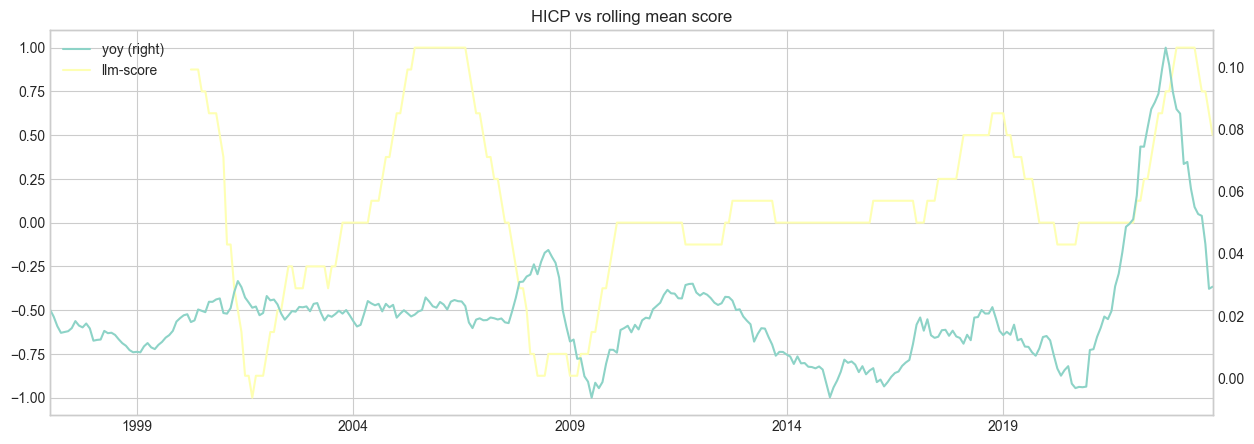

In [66]:
merged_df.plot(secondary_y='yoy', figsize=(15, 5), title="HICP vs rolling mean score")

In [2]:
import pandas as pd

,label,code
0,Harmonised overall,000
1,Food and non-alcoholic beverages,001
2,Food,0011
3,Bread and cereals,00111
4,Rice,001111
...,...,...
411,Other services n.e.c.,1270
412,Administrative fees,12701
413,Legal services and accountancy,12702
414,Funeral services,12703


## Explaining chatgpt hawkishness

Beyond the simple validation of the LLM score in the previous section, we can go deeper and identify the words associated with hawkishness (or dovishness) as interpreted by the language model. To do so, we run a regression where the target is the LLM score and the features are `tfidf` values for the main tokens. 

In [12]:
from skfin.text import show_text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import Pipeline
from skfin.text import coefs_plot, show_text

In [13]:
est = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                vocabulary=None,
                ngram_range=(1, 3),
                max_features=500,
                stop_words="english",
                token_pattern=r"\b[a-zA-Z]{3,}\b",
            ),
        ),
        ("reg", ElasticNet(alpha=0.0075)),
    ]
)

X = statements_["text"]

In [14]:
interpret_coefs = {}
for c in ['hawkish', 'neutral', 'dovish']: 
    y = statements_[c]
    est.fit(X, y)
    vocab_ = pd.Series(est.named_steps["tfidf"].vocabulary_).sort_values().index
    interpret_coefs[c] = pd.Series(np.transpose(est.named_steps["reg"].coef_), index=vocab_)

In [15]:
d = {k: v.nlargest(n=10) for k, v in interpret_coefs.items()}

Words associated to tightening are on the `hawkish` side ("raise target", "pressures", "inflation", etc). A bit more mixed resuts on the other side. 

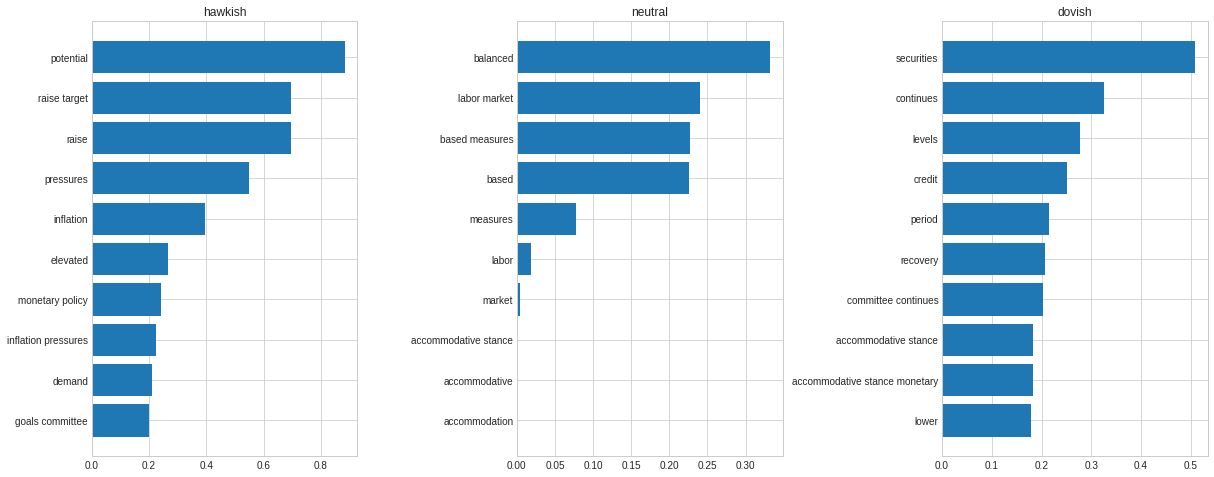

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
fig.subplots_adjust(wspace=.6)
for i, (k, v) in enumerate(d.items()): 
    bar(v, horizontal=True, ax=ax[i], title=k)

## Topics using KeyLLM 

To further study the corpus, we can use LLMs to identify topics in documents. The package `keybert` just does that. 

In [30]:
#pip install keybert 

In [22]:
from keybert.llm import OpenAI
from keybert import KeyLLM

In [23]:
llm = OpenAI()
kw_model = KeyLLM(llm)
keywords = kw_model.extract_keywords(statements['text'].to_list()) 

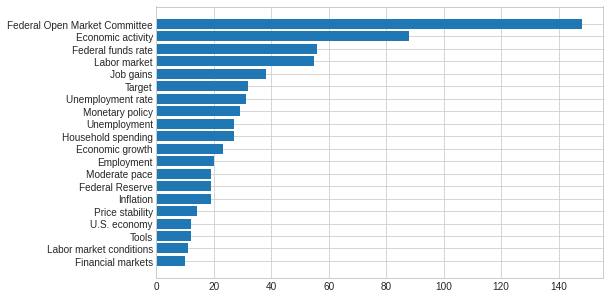

In [24]:
bar(pd.Series([w for v in keywords for w in v if len(w)>0]).value_counts().head(20), horizontal=True)

Below we show the top 3 topics for certain events.

In [25]:
statements_kw = pd.concat([pd.Series(v).iloc[:3] for v in keywords], axis=1).T.set_index(statements.index)

In [27]:
statements_kw.loc['2001-09':'2001-12']

,0,1,2
release_date,,,
2001-09-17,Tragic events,Employment,Production
2001-10-02,Terrorist attacks,Uncertainty,Economy
2001-11-06,Uncertainty,Deterioration,Business conditions
2001-12-11,Economic activity,Inflation,Demand


In [29]:
statements_kw.loc['2020-03']

,0,1,2
release_date,,,
2020-03-03,U.S. economy,Strong,Coronavirus
2020-03-15,Coronavirus,Economic impact,Federal Open Market Committee
2020-03-23,Federal Reserve,Tools,US economy
2020-03-31,Federal Reserve,Temporary repurchase agreement facility,Foreign
